<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/EWMA_%26_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-04 12:06:15--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-04 12:06:15 (29.7 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

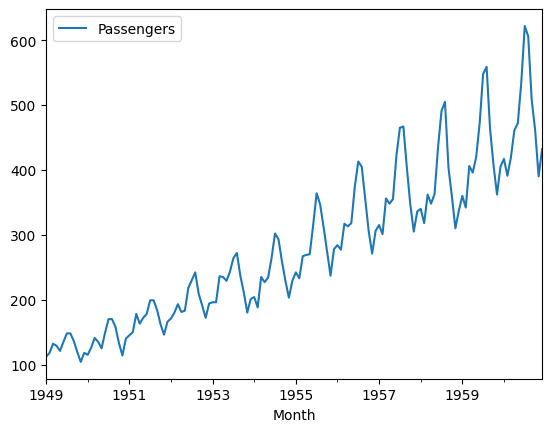

In [6]:
df.plot();

In [7]:
alpha = 0.2

In [8]:
df['EWMA'] = df['Passengers'].ewm(alpha = alpha,adjust = False).mean()

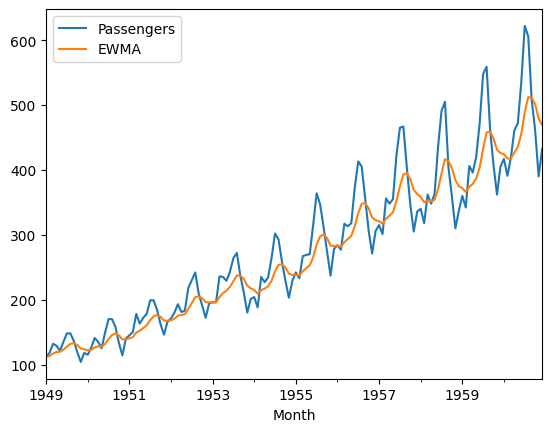

In [9]:
df.plot();

In [10]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
     xhat = alpha * x + (1-alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['manual'] = manual_ewma

<Axes: xlabel='Month'>

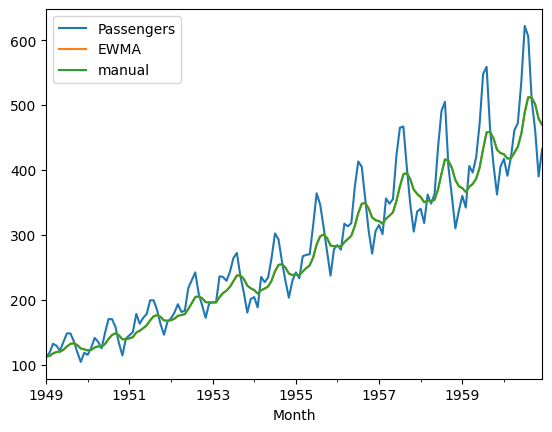

In [12]:
df.plot()

In [13]:
df.head()

,Passengers,EWMA,manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
df.drop('manual',axis = 1,inplace = True)

# **Holt-Winters**

In [ ]:
!pip install statsmodels

In [16]:
 from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
# 'MS' indicates month
df.index.freq = 'MS'

In [20]:
res = ses.fit(smoothing_level = alpha,optimized = False)

In [21]:
res

In [22]:
res.predict(start=df.index[0],end = df.index[-1])

1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
df['SES'] = res.predict(start = df.index[0],end = df.index[-1])

In [26]:
#Check values
np.allclose(df['SES'],res.fittedvalues)

True

<Axes: xlabel='Month'>

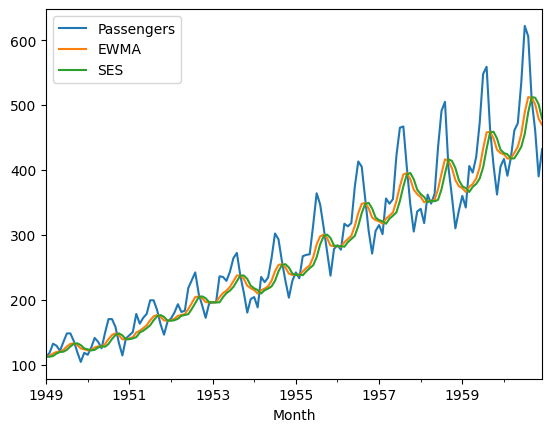

In [27]:
df.plot()

In [28]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [29]:
df['SES-1'] = df['SES'].shift(-1)

In [30]:
df.head()

,Passengers,EWMA,SES,SES-1
Month,,,,
1949-01-01,112,112.0000,112.000,112.0000
1949-02-01,118,113.2000,112.000,113.2000
1949-03-01,132,116.9600,113.200,116.9600
1949-04-01,129,119.3680,116.960,119.3680
1949-05-01,121,119.6944,119.368,119.6944


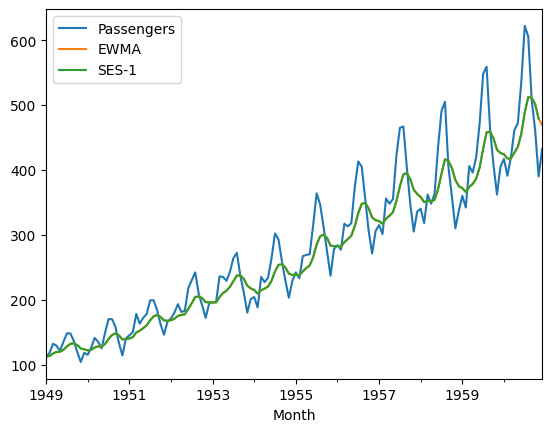

In [31]:
#Wrong
#SES is originally lagging behind 1 step
df[['Passengers','EWMA','SES-1']].plot();

In [37]:
 #Split the data into training and testing sets
 N_test = 12

 #From 0 to stop b4 last 12 rows
 train = df.iloc[:-N_test]

 #Last 12 rows
 test = df.iloc[-N_test:]

In [40]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic'
)
res = ses.fit()

In [41]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

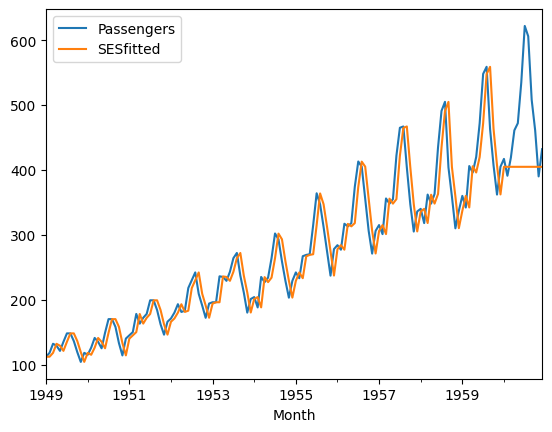

In [45]:
df.loc[train_idx,'SESfitted'] = res.fittedvalues
df.loc[test_idx,'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot();

In [46]:
#smoothing level is 0.995 very close to 1
#which means the predicted value is copied the previous value
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}